<a href="https://colab.research.google.com/github/RyutaroHashimoto/gigwork_quest_blue/blob/katsuta/Image_Recognition_AI_GIG_Work_Quest_1_Team_Brue_EFNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
# # !pip install tensorflow-addons==0.6.0
# # !pip install tensorflow-io==0.9.1
# # !pip install efficientnet
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-lexxaodt
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-lexxaodt
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18421 sha256=5383c68352558d3b2b4314d7715c00ab90c01c57ecd054487bf16ac3aa1c2fad
  Stored in directory: /tmp/pip-ephem-wheel-cache-3alf7ykf/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [2]:
!nvidia-smi

Sun Mar 14 08:16:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

 # Import library

In [3]:
# ライブラリの読み込み

import os
import sys
import random
import shutil
import gc
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import keras.models as M
import keras.layers as L
import keras.backend as K
import tensorflow as tf

from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.constraints import max_norm
from keras.applications.imagenet_utils import decode_predictions
from PIL import Image, ImageEnhance, ImageOps
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from efficientnet.keras import EfficientNetB0
from efficientnet.keras import EfficientNetB7
from efficientnet.keras import center_crop_and_resize, preprocess_input
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D

In [7]:
# ディレクトリ移動
%cd drive/MyDrive/AI Quest

/content/drive/MyDrive/AI Quest


In [8]:
!ls

 GIG_Works_Team_Blue_20210313_FInetunig.ipynb   SaveModels	   X_train.npy
'Image Recognition_Efn.png'		        Submit		   Y_train.npy
 label_master.tsv			        train_master.tsv
 sample_submit.csv			        X_test.npy


# Reading Data

In [9]:
labels = pd.read_csv("train_master.tsv", sep="\t") #教師ラベルの読み込み

In [10]:
labels.head()

,file_name,label_id
0,train_00000.png,11
1,train_00001.png,15
2,train_00002.png,4
3,train_00003.png,14
4,train_00004.png,1


In [11]:
master = pd.read_csv("label_master.tsv", sep="\t") #ラベルマスタの読み込み

In [12]:
master.head()

,label_id,label_name
0,0,aquatic_mammals
1,1,fish
2,2,flowers
3,3,food_containers
4,4,fruit_and_vegetables


In [13]:
sample = pd.read_csv("sample_submit.csv", header=None, sep=",")

In [14]:
sample.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,test_00000.png,0.036151,0.014607,0.034591,0.079934,0.053778,0.011690,0.039329,0.079885,0.047027,0.055246,0.062593,0.037947,0.080989,0.066377,0.020849,0.057315,0.056351,0.033405,0.078505,0.053430
1,test_00001.png,0.033393,0.037818,0.021027,0.043661,0.082885,0.041105,0.069309,0.059735,0.023879,0.001008,0.077569,0.053666,0.044468,0.040490,0.090077,0.050215,0.052718,0.067940,0.030642,0.078394
2,test_00002.png,0.098902,0.047091,0.022525,0.059422,0.038273,0.011877,0.086344,0.054882,0.046612,0.050381,0.028493,0.027183,0.092749,0.076549,0.026914,0.099406,0.032409,0.038710,0.000611,0.060666
3,test_00003.png,0.054705,0.080344,0.047048,0.083701,0.043293,0.068830,0.026523,0.076391,0.008649,0.071797,0.020802,0.054486,0.065079,0.060174,0.045692,0.052243,0.006735,0.036344,0.070731,0.026432
4,test_00004.png,0.087472,0.045188,0.091187,0.003265,0.110322,0.102048,0.048273,0.080005,0.050142,0.018821,0.096636,0.038774,0.050342,0.044085,0.057429,0.023512,0.018324,0.002596,0.030469,0.001106


In [15]:
X_train = np.load('X_train.npy')

In [16]:
Y_train = np.load('Y_train.npy')

In [17]:
X_test = np.load('X_test.npy')

# Normalization

In [18]:
train = X_train / 255
test = X_test / 255

# Splitting Data

In [19]:
# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(train, Y_train):
    X_train_image, X_val_image, y_train_label, y_val_label = train[train_index], train[val_index], Y_train[train_index], Y_train[val_index]
    
print("The number of training data : ", X_train_image.shape[0])
print("The number of validation data : ", X_val_image.shape[0])

The number of training data :  40000
The number of validation data :  10000


# Setting Callbacks

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

In [21]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

In [22]:
# ModelCheckpoint
weights_dir='/content/drive/MyDrive/AI Quest/SaveModels/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)


# Setting Various Parameters

In [31]:
batch_size = 32
epochs = 50

steps_per_epoch  = X_train_image.shape[0] // batch_size
validation_steps = X_val_image.shape[0] // batch_size

# Data Augmentation

In [23]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

# Fine Tuning by EfficientNetB0

### （１）Resizing images

In [24]:
inputs = tf.keras.Input(shape=(None, None, 3))
x = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (224, 224)))(inputs)
# x = tf.keras.layers.Lambda(EfficientNetB0.)(x)

### （２）Loading the trained model

In [25]:
# from efficientnet import EfficientNetB0
input_shape = (224, 224, 3)
base_model = EfficientNetB0(
                            input_shape=input_shape,
                            weights='imagenet',
                            include_top=False,
                            drop_connect_rate=0.4, #正則化 defalt値は0.2
                            input_tensor=x)


16809984/16804768 [==============================] - 0s 0us/step


### （３）Rebuild the model

In [26]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.25)(x)
predictions = Dense(20, activation='softmax')(x)

In [29]:
# base_model.trainable = False

In [27]:
# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

In [28]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
______________________________________________________________________________________________

### （４）Training the model

In [29]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
%%time

hist = model.fit_generator(
                           datagen.flow(X_train_image, y_train_label, batch_size = batch_size),
                           steps_per_epoch = X_train_image.shape[0] // batch_size,
                           epochs = epochs,
                           validation_data = (X_val_image, y_val_label),
                           callbacks = [early_stopping, reduce_lr],
                           shuffle = True,
                           verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1250/1250 [==============================] - 367s 293ms/step - loss: 0.8319 - accuracy: 0.7368 - val_loss: 0.7937 - val_accuracy: 0.7513
Epoch 2/50
1250/1250 [==============================] - 366s 293ms/step - loss: 0.7137 - accuracy: 0.7739 - val_loss: 0.7229 - val_accuracy: 0.7808
Epoch 3/50
1250/1250 [==============================] - 367s 293ms/step - loss: 0.6325 - accuracy: 0.7970 - val_loss: 0.6842 - val_accuracy: 0.7954
Epoch 4/50
1250/1250 [==============================] - 366s 293ms/step - loss: 0.5790 - accuracy: 0.8141 - val_loss: 1.1862 - val_accuracy: 0.6674
Epoch 5/50
1250/1250 [==============================] - 367s 293ms/step - loss: 0.5192 - accuracy: 0.8328 - val_loss: 0.6751 - val_accuracy: 0.8034
Epoch 6/50
1250/1250 [==============================] - 367s 294ms/step - loss: 0.4832 - accuracy: 0.8442 - val_loss: 0.7620 - val_accuracy: 0.7797
Epoch 7/50
1250/1250 [==============================] - 363s 290ms/step - loss: 0.4493 - accuracy: 0.8576 - val_

In [ ]:
%%time
# hist = model.fit(X_train_image, y_train_label, epochs=epochs,
# #                  validation_split=0.1,
#                  validation_data=(X_val_image, y_val_label),
#                  verbose=1, 
#                  callbacks = [early_stopping, reduce_lr],
#                  batch_size=batch_size)

### （５）Evaluating the model

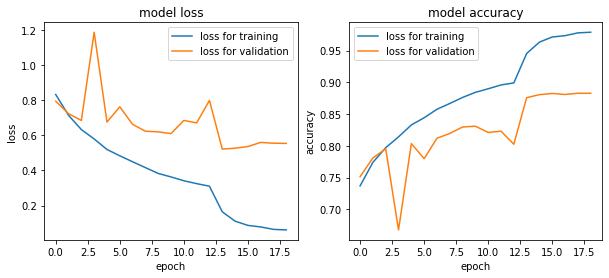

In [35]:
# ----------------------------------------------
# Some plots
# ----------------------------------------------
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# loss
def plot_history_loss(fit):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

# acc
def plot_history_acc(fit):
    # Plot the loss in the history
    axR.plot(fit.history['accuracy'],label="loss for training")
    axR.plot(fit.history['val_accuracy'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper left')

plot_history_loss(hist)
plot_history_acc(hist)
plt.show()
fig.savefig('Image Recognition_Efn.png')
plt.close()

In [36]:
score_Efn = model.evaluate(X_val_image, y_val_label, verbose=1)
print("evaluate loss: {0[0]}".format(score_Efn))
print("evaluate acc: {0[1]}".format(score_Efn))

313/313 [==============================] - 17s 53ms/step - loss: 0.5538 - accuracy: 0.8828
evaluate loss: 0.5537781119346619
evaluate acc: 0.8827999830245972


In [37]:
predictions_val_Efn = model.predict(X_val_image)
from sklearn.metrics import log_loss
log_loss_Efn = log_loss(y_val_label,predictions_val_Efn)
print("EfficinetNetB0_logloss:{0}".format(log_loss_Efn))

EfficinetNetB0_logloss:0.5535896881108601


### （６）Test Time Augmentation with Validation Data

In [61]:
def tta(model,test_size,generator,batch_size ,epochs = 10):
    #test_time_augmentation
    #batch_sizeは，test_sizeの約数でないといけない．
    pred = np.zeros(shape = (test_size,20), dtype = float)
    step_per_epoch = test_size //batch_size
    for epoch in range(epochs):
        for step in range(step_per_epoch):
            sta = batch_size * step
            end = sta + batch_size
            tmp_x = generator.__next__()
            pred[sta:end] += model.predict(tmp_x)
    return pred / epochs

def tta_generator(test):
    return ImageDataGenerator(rotation_range = 0 , 
                              height_shift_range = 0.1,
                              width_shift_range = 0.1,
                              horizontal_flip = True,
                              vertical_flip = False).flow(test,batch_size = batch_size,shuffle = False)


In [60]:
batch_size = 20
tta_epochs = 20
tta_pred_Efn = tta(model,X_val_image.shape[0],tta_generator(),batch_size,epochs = tta_epochs)

TTA_log_loss_Efn = log_loss(y_val_label,tta_pred_Efn)

print( accuracy_score( np.argmax(tta_pred_Efn,axis = 1) , np.argmax(y_val_label,axis = 1)))
print( "TTA_EfficinetNetB0_logloss:{0}".format(TTA_log_loss_Efn))

0.8903
TTA_EfficinetNetB0_logloss:0.4157108339825394


### （７）Predicting Image Classification

In [62]:
batch_size = 20
tta_epochs = 50
tta_prediciton_Efn = tta(model,test.shape[0],tta_generator(test),batch_size ,epochs = tta_epochs)

In [65]:
file_name = sample[0]
df = pd.DataFrame(tta_prediciton_Efn)
df_concat = pd.concat([file_name, df],axis=1)
df_concat.head()

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,test_00000.png,3.106754e-02,8.573319e-05,3.059332e-06,1.661134e-06,1.134488e-06,9.259645e-05,8.558634e-06,1.105594e-05,5.313822e-06,8.582431e-01,3.166147e-02,3.794439e-06,2.560286e-05,9.585843e-04,7.179079e-04,9.307319e-06,1.846363e-06,6.457639e-04,7.607601e-02,3.799699e-04
1,test_00001.png,1.178407e-08,4.435851e-07,6.088591e-10,1.957069e-06,1.231486e-08,8.061025e-08,9.868186e-07,3.426418e-08,9.276632e-08,5.362813e-05,9.976101e-01,3.563092e-05,1.274417e-08,3.453259e-07,2.191295e-05,2.055802e-08,3.678166e-06,2.269027e-03,1.441159e-07,1.878198e-06
2,test_00002.png,9.999824e-01,2.535454e-08,9.498488e-20,3.443055e-14,2.402684e-14,1.359678e-16,1.851833e-14,5.487354e-11,8.479371e-11,4.402303e-11,2.567120e-10,1.376621e-11,7.432290e-12,2.085514e-12,6.258706e-14,1.762933e-05,6.965027e-11,1.486478e-14,4.331441e-13,5.796984e-13
3,test_00003.png,1.206502e-10,1.002345e-07,1.026697e-09,2.106684e-11,9.999997e-01,1.793521e-08,2.199587e-07,3.496989e-11,1.096458e-11,7.238588e-11,5.054794e-10,4.006314e-10,3.638207e-10,2.065256e-09,4.365635e-11,2.719229e-09,3.144283e-11,7.733210e-12,2.894885e-13,1.201559e-12
4,test_00004.png,2.070523e-10,1.287736e-09,5.604270e-11,1.964451e-13,4.526959e-12,2.681752e-09,2.003820e-10,1.027435e-12,1.418828e-12,2.730019e-09,1.000000e+00,3.058515e-11,3.119004e-14,4.295305e-10,1.061499e-12,5.290790e-13,2.235977e-12,4.499799e-09,1.830619e-12,2.588462e-12


In [66]:
df_concat.to_csv('/content/drive/MyDrive/AI Quest/Submit/submit_TTA_EffNet_dcr0.4_Logloss{0}.csv'.format(TTA_log_loss_Efn),index = False, header=None)